<a href="https://colab.research.google.com/github/Abhilaksh1498/SoC-20-Chatbot/blob/master/Text_generation_Char_level_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhilakshmaheshwari","key":"b4131928857e3bb171320644901f7a27"}'}

In [0]:
import tensorflow as tf
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json
! mkdir kaggle_dataset

In [4]:
# We'll use Shakespeare plays text from kaggle
!kaggle datasets download -d kingburrito666/shakespeare-plays -p /content/kaggle_dataset

100% 4.55M/4.55M [00:00<00:00, 30.7MB/s]



In [5]:
!unzip /content/kaggle_dataset/shakespeare-plays.zip -d /content/kaggle_dataset

Archive:  /content/kaggle_dataset/shakespeare-plays.zip
  inflating: /content/kaggle_dataset/Shakespeare_data.csv  
  inflating: /content/kaggle_dataset/alllines.txt  
  inflating: /content/kaggle_dataset/william-shakespeare-black-silhouette.jpg  


In [0]:
entire_play = open(r'/content/kaggle_dataset/alllines.txt').readlines()

In [0]:
entire_play = [x[:-1].strip('"') for x in entire_play]

In [0]:
entire_play = '\n'.join(entire_play)
entire_play = entire_play.lower()

In [0]:
# We'll implement character level since one-hot encoding of tokens may cause memory error
# instead our target will be individual characters
# once we recognise that its basically a classification problem
uniq_char = sorted(set(entire_play))
char_index = {}
rev_index_char = {}
char_index = {u:i for i, u in enumerate(uniq_char)}
rev_index_char = {i:u for i, u in enumerate(uniq_char)}
vocab_size = len(uniq_char)


In [0]:
# len(entire_play) ~ 43 lakh
seq_length = 75
X_train = []
y = []
for i in range(0,len(entire_play)- seq_length, seq_length+1):
  X_train.append(list(entire_play[i:i+seq_length]))
  y.append(entire_play[i+seq_length])

In [0]:
for i in range(len(X_train)):
  X_train[i] = [char_index[x] for x in X_train[i]]
  y[i] = char_index[y[i]]

In [0]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [0]:
X_train = np.array(X_train)
y = np.array(y)
y = to_categorical(y)

In [0]:
print(y.shape)
print(X_train.shape)
print(vocab_size)

(57451, 51)
(57451, 75)
51


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.1, random_state=42)

### We can notice that model is not so complex as it isn't able to provide good train accuracy 

In [0]:
!mkdir saved_model
checkpoint_path = '/content/saved_model'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, save_freq='epoch')

In [19]:

LATENT_DIM = 256
input_ = tf.keras.layers.Input(shape=( seq_length , ))
initial_h = tf.keras.layers.Input(shape=(LATENT_DIM,))
embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_length, 
                           weights=[embeddings_matrix], trainable=False)(input_)
gru = tf.compat.v1.keras.layers.CuDNNGRU(LATENT_DIM , recurrent_initializer='glorot_uniform', return_state= True)     # dimensionality of the output space
rnn_output,_ = gru(embedding)
dense = tf.keras.layers.Dense(vocab_size, activation='sigmoid')
output = dense(rnn_output)
model = tf.keras.models.Model([input_, initial_h],output)
model.summary()
num_epochs = 5
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 50)       2550        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru (CuDNNGRU)            [(None, 256), (None, 236544      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
______________________________________________________________________________________________

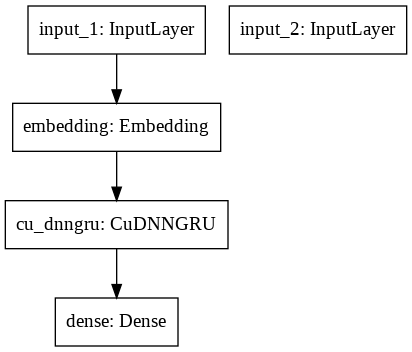

In [22]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(model)


In [56]:
z = np.zeros((len(X_train),LATENT_DIM))
num_epochs = 20
r = model.fit([X_train,z], y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[cp_callback])

Epoch 1/20
1615/1616 [============================>.] - ETA: 0s - loss: 1.6960 - accuracy: 0.4722
Epoch 00001: saving model to /content/saved_model
1616/1616 [==============================] - 14s 9ms/step - loss: 1.6961 - accuracy: 0.4722 - val_loss: 1.8157 - val_accuracy: 0.4513
Epoch 2/20
1612/1616 [============================>.] - ETA: 0s - loss: 1.6333 - accuracy: 0.4880
Epoch 00002: saving model to /content/saved_model
1616/1616 [==============================] - 14s 9ms/step - loss: 1.6337 - accuracy: 0.4878 - val_loss: 1.8143 - val_accuracy: 0.4572
Epoch 3/20
1612/1616 [============================>.] - ETA: 0s - loss: 1.5725 - accuracy: 0.5019
Epoch 00003: saving model to /content/saved_model
1616/1616 [==============================] - 14s 9ms/step - loss: 1.5729 - accuracy: 0.5018 - val_loss: 1.7962 - val_accuracy: 0.4671
Epoch 4/20
1613/1616 [============================>.] - ETA: 0s - loss: 1.5100 - accuracy: 0.5169
Epoch 00004: saving model to /content/saved_model
1616/1

KeyboardInterrupt: ignored

In [0]:
# Generate poetry
def gen_text(num_chars = 25):
  seed_text = input('Enter seed text: ').lower()
  seed_text= np.array([[char_index[seed_text[0]]]])
  # Making a sampling model
  input_2 = tf.keras.layers.Input(shape=(1,))
  embedding_sampling = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_length, 
                                                weights=[embeddings_matrix], trainable=False)(input_2)
  gru_output, h = gru(embedding_sampling, initial_state = [initial_h])
  output_sampling = dense(gru_output)

  sampling_model = tf.keras.models.Model(inputs = [input_2, initial_h], outputs = [output_sampling, h] )
  play = True
  state_h = np.zeros((1,LATENT_DIM))
  generated_text = ''
  while(play):
    for _ in range(num_chars):
      prob, state_h = sampling_model.predict([seed_text,state_h])
      # for poetry generation instead of using greedy approach we'll sample the characters based on probability distributions
      prob /= prob.sum() # Sum of prob = 1, (the sigmoid function ensures each entry between 0 and 1)
      next_charIndex = np.random.choice(a = vocab_size, p = prob[0])
      generated_text += rev_index_char[next_charIndex]
      seed_text = np.array([[next_charIndex]]) 
    play_again = input('Do you want to generate again? (y/n)')
    play = True if (play_again.lower()=='y') else False
  print(generated_text)
  return 

In [40]:
print(np.array([char_index['a']]).shape)

(1,)


In [60]:
gen_text()

Enter seed text: H
Do you want to generate again? (y/n)y
Do you want to generate again? (y/n)y
Do you want to generate again? (y/n)y
Do you want to generate again? (y/n)n
, trot now, but my degrez have i in that teon, then brother pandly in
farleds
the
glibeus, but, apte


In [16]:
! mkdir pre_trained_vec
! kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation -p /content/pre_trained_vec

 98% 448M/458M [00:11<00:00, 32.7MB/s]
100% 458M/458M [00:11<00:00, 43.0MB/s]


In [17]:
! unzip /content/pre_trained_vec/glove-vectors.zip -d /content/pre_trained_vec
# We'll use 50d vectors
glove = open(r'/content/pre_trained_vec/glove.6B.50d.txt', 'r').read()
import numpy as np
embedding_dict = {}
for line in glove.split('\n')[:-1]:
  line = line.split()
  embedding_dict[line[0]] = np.asarray(line[1:], dtype = 'float32')

Archive:  /content/pre_trained_vec/glove-vectors.zip
  inflating: /content/pre_trained_vec/glove.6B.100d.txt  
  inflating: /content/pre_trained_vec/glove.6B.200d.txt  
  inflating: /content/pre_trained_vec/glove.6B.50d.txt  


In [0]:
embedding_dim = 50
embeddings_matrix = np.zeros((vocab_size, embedding_dim)); # 0th index will be padding
not_found_chars = []
for char,index in char_index.items():
  vec = embedding_dict.get(char)         # if word is not present it returns None as value
  if vec is not None:
    embeddings_matrix[index] = vec       # words in corpus not found in glove (including oov_token) will be given 0 vector
  else:
    not_found_chars.append(char)

I'll copy the code directly and try to run it